In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set_context('talk')
np.set_printoptions(suppress=True) 
    ### not xEyy format(science float format)
%matplotlib inline    

In [2]:
import scipy.io
data = scipy.io.loadmat('ex3data1.mat')

X = data['X']
y = data['y']

In [3]:
def displayData(X, ex_width=0, fig_size=4):
    m, n = X.shape
    if ex_width == 0:
        ex_width = int(math.sqrt(n))
    ex_height = n/ex_width
    rows = int(math.sqrt(m))
    cols = int(m/rows)
    pad = 2
    
    display_arr = -np.ones([pad + rows * (ex_width + pad),
                       pad + cols * (ex_height + pad)])

    idx = 0
    for i in range(rows):
        for j in range(cols):
            max_val = np.max(np.abs(display_x[idx]))
            display_arr[
                (pad + i*(ex_width+pad)) : ((i+1)*(ex_width+pad)), 
                (pad + j*(ex_height+pad)) : ((j+1)*(ex_height+pad))
            ] = display_x[idx].reshape(ex_height, ex_width).T/max_val
            idx += 1

    plt.figure(figsize=(fig_size,fig_size));
    plt.imshow(display_arr, cmap='gray');

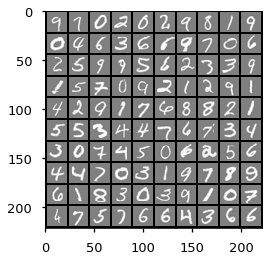

In [4]:
rand_indices = np.random.permutation(len(X))[:100]
display_x = X[rand_indices]
displayData(display_x)

In [5]:
data = scipy.io.loadmat('ex3weights.mat')
Theta1 = data['Theta1']
Theta2 = data['Theta2']
print X.shape
print Theta1.shape
print Theta2.shape

(5000, 400)
(25, 401)
(10, 26)


In [6]:
nn_params = np.append(Theta1.flatten(), Theta2.flatten())
nn_params.shape = (-1,1)
nn_params.shape

(10285, 1)

In [7]:
def reshapeTheta(nn_params, input_layer_size,
                hidden_layer_size, num_labels):
    theta1_n = hidden_layer_size *(input_layer_size+1)
    theta1 = nn_params[:theta1_n].reshape(
            hidden_layer_size, input_layer_size+1)
    theta2 = nn_params[theta1_n:].reshape(
            num_labels, hidden_layer_size+1)
    return theta1, theta2

In [8]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
theta1, theta2 = reshapeTheta(nn_params, input_layer_size,
                             hidden_layer_size, num_labels)
print theta1.shape
print theta2.shape
print (theta1==Theta1).astype(int).prod().astype(bool)
print (theta2==Theta2).astype(int).prod().astype(bool)

(25, 401)
(10, 26)
True
True


In [9]:
def sigmoid(z):
    return (1.0/(1.0+np.exp(-z)))

def expandY(y):
    yy = np.zeros([len(y), 10])
    for i in xrange(len(y)):
        j = y[i] -1
        yy[i, j] = 1
    return yy

def nnCostJ(nn_params, *args):
    (input_layer_size, 
     hidden_layer_size,
     num_labels,
     X, y, lamb) = args
    
    theta1, theta2 = reshapeTheta(nn_params, input_layer_size,
                                 hidden_layer_size, num_labels)
    m  = len(X)
    X  = np.append(np.ones([m, 1]), X, axis=1)
    Z2 = np.dot(X, theta1.T)
    A2 = sigmoid(Z2)
    A2 = np.append(np.ones([m, 1]), A2, axis=1)
    Z3 = np.dot(A2, theta2.T)
    A3 = sigmoid(Z3)
    hx = A3
    y = expandY(y)
    J1 = -y * np.log(hx)
    J2 = (1.0 - y) * np.log(1.0 - hx)
    J = 1.0/m * np.sum(J1-J2)
    
    theta1_but0 = theta1[:, 1:]
    theta2_but0 = theta2[:, 1:]
    J3 = lamb/(2.0*m) * (
        np.sum(theta1_but0**2) + np.sum(theta2_but0**2))
    J = J+J3
    return J

def nnCostGrad(nn_params, *args):
    (input_layer_size, 
     hidden_layer_size,
     num_labels,
     X, y, lamb) = args
    
    theta1, theta2 = reshapeTheta(nn_params, input_layer_size,
                                 hidden_layer_size, num_labels)
    theta1_grad = np.zeros([len(theta1),1])
    theta2_grad = np.zeros([len(theta2),1])
    
    ## unroll gradients
    grad = np.append(theta1_grad, theta2_grad)
    return grad

In [10]:
def nnCostFunction(nn_params, input_layer_size,
                  hidden_layer_size, num_labels,
                  X, y, lamb):
    J = nnCostJ(nn_params, input_layer_size, hidden_layer_size,
               num_labels, X, y, lamb)
    grad = nnCostGrad(nn_params, input_layer_size, hidden_layer_size,
                     num_labels, X, y, lamb)
    return J, grad

In [11]:
lamb = 0.0
J, grad = nnCostFunction(nn_params, input_layer_size, 
                         hidden_layer_size, num_labels,
                         X, y, lamb)
print J   ### 0.287629

0.2876291651613189


In [12]:
lamb = 1.0
J, grad = nnCostFunction(nn_params, input_layer_size,
                        hidden_layer_size, num_labels,
                        X, y, lamb)
print J   ### 0.383770

0.38376985909092365


In [13]:
def sigmoidGradient(z):
    return sigmoid(z) * (1-sigmoid(z))

In [22]:
g = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))
print g.round(6)

[0.196612 0.235004 0.25     0.235004 0.196612]


In [55]:
def randInitializeWeights(L_in, L_out):
    eps = 0.12
    return np.random.rand(L_out, L_in+1)*2*eps-eps

In [56]:
def debugInitializeWeights(fan_out, fan_in):
    w = np.zeros([fan_out, fan_in +1])
    w = np.sin(np.arange(1, w.size+1)).reshape(w.shape)
    e = 1e-4
    
    return w

In [59]:
def computeNumericalGradient(Jfunc, theta, *args):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    return numgrad

In [63]:
computeNumericalGradient(nnCostJ, np.ones([5,5]),
                         input_layer_size, hidden_layer_size,
                         num_labels, X, y, lamb)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [65]:
def checkNNGradients(lamb):
    pass